# Exercises 5

*Antti Härkönen*

## 1.

Posterior distribution of the latent variables factorises if they are independent, i.e.
 $ z_n \perp\!\!\!\perp z_{m \neq n} \mid x_n, \mu, \sigma^2, \pi $. The hyperparameter $\pi$ is the only node from which
 $\bf Z$ nodes can be reached, and since it is always a fork between two child nodes, path through it is blocked.

$ p(\bf Z \mid \bf X, \mu, \sigma^2, \pi) $

$ = \prod\limits_{n=1}^N p(z_n \mid x_n, \mu, \sigma^2, \pi) $


## 2.

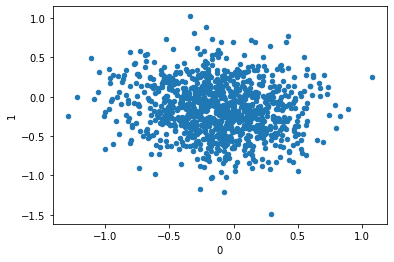

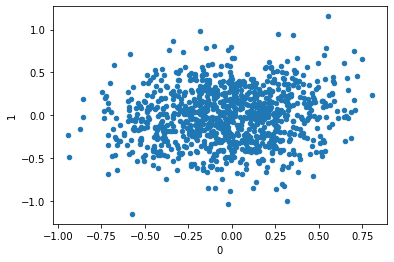

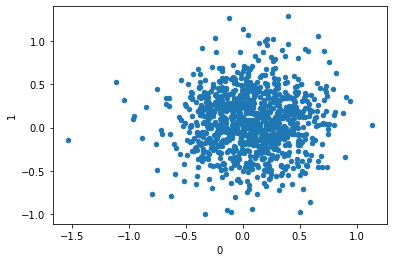

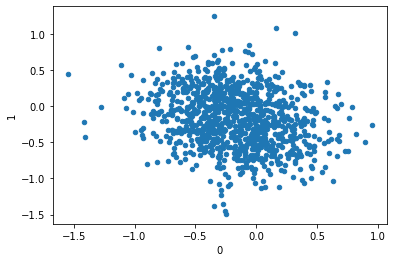

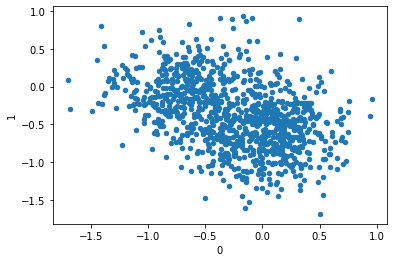

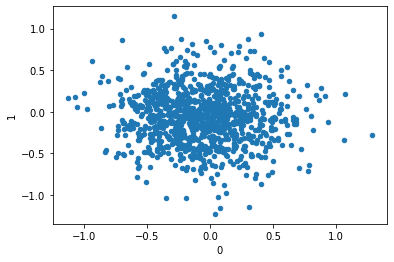

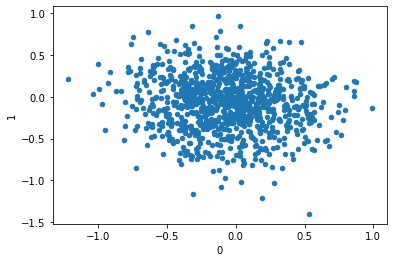

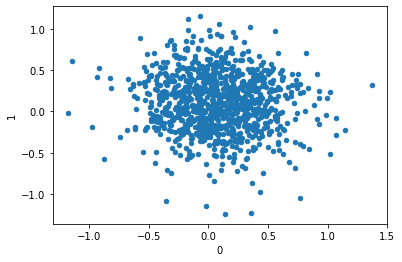

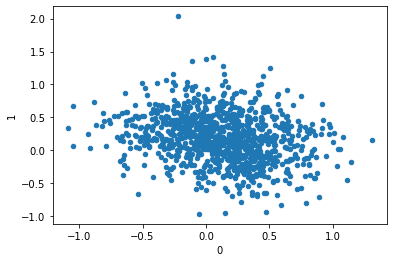

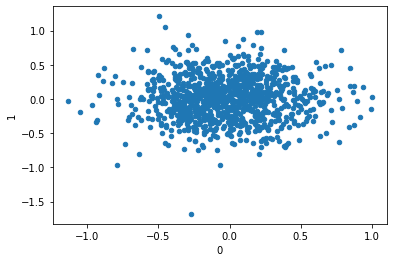

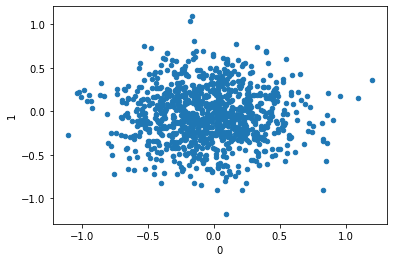

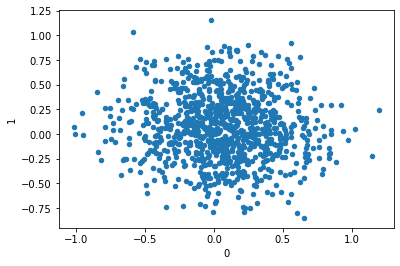

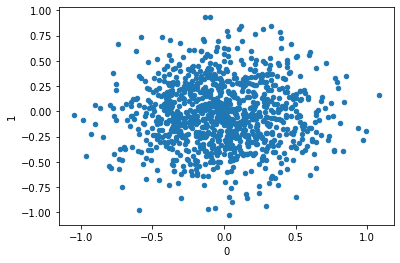

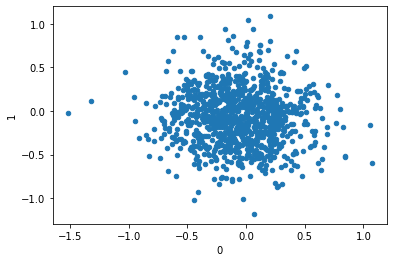

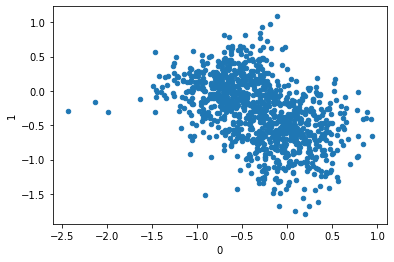

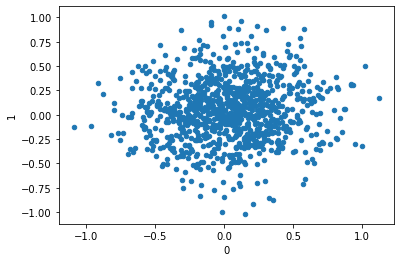

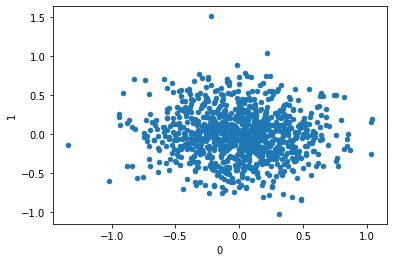

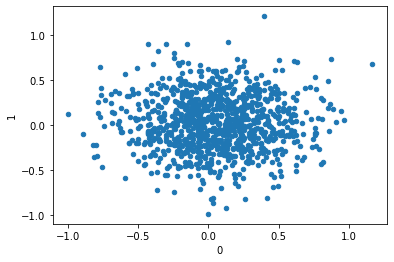

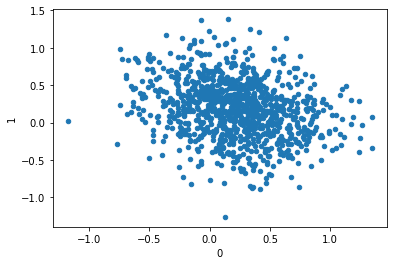

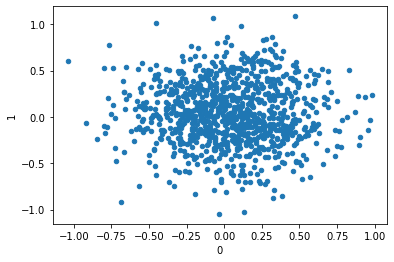

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow_probability as tfp
tfd = tfp.distributions


class GibbsSampler:
    def __init__(self, data, iterations=1000, burn_in=100):
        self.N, self.M = data.shape
        self.X = data
        self.iterations = iterations
        self.burn_in = burn_in
        self.samples = []
        mu = np.random.uniform(data.min(), data.max(), size=self.M)
        z = tfd.OneHotCategorical(logits=np.ones(self.M)).sample(self.N).numpy()
        var = np.ones(self.M)
        self.samples.append({'t': 0, 'mu': mu.copy(), 'z': z.copy()})
        x_bar = 1

        for t in range(1, self.iterations + self.burn_in + 1):
            for n in range(self.N):
                z[n] = tfd.OneHotCategorical(
                    logits=tfd.Normal(mu, var).prob(self.X[n])
                ).sample(1).numpy()
            for m in range(self.M):
                members = z[:, m].sum()
                if members != 0:
                    x_bar = z[:, m] * x / members
                lambda_hat = 1 / (members / var[m] + t**(-2))
                mu_hat = lambda_hat * (members / var[m] * x_bar + mu[m] / t**2)
                mu[m] = np.random.normal(
                    loc=mu_hat,
                    scale=lambda_hat**0.5,
                    size=1,
                )
            self.samples.append({'t': t, 'mu': mu.copy(), 'z': z.copy()})

    def sample(self, n):
        return self.samples[self.burn_in + n]

    @property
    def mu(self):
        return [el['mu'] for el in self.samples[self.burn_in:]]

    def plot(self):
        df = pd.DataFrame(self.mu)
        df.plot.scatter(x=0, y=1)


n = 20
K = 2, 4, 16, 256
sigmas = 0.25, 0.5, 1., 2., 4.

for k in K:
    for sigma_0 in sigmas:
        alpha = np.ones(k, dtype=np.float)
        theta = tfd.Dirichlet(alpha).sample(1).numpy()
        z = tfd.Categorical(probs=theta).sample(n).numpy()

        mu_x = tfd.Normal(np.zeros(k), np.repeat(sigma_0, k)).sample(n).numpy()
        mu_zx = np.squeeze(np.take_along_axis(mu_x, z, 1))
        x = np.squeeze(tfd.Normal(mu_zx, np.ones(n)).sample(1).numpy())

        mu_y = tfd.Normal(np.zeros(k), np.repeat(sigma_0, k)).sample(n).numpy()
        mu_zy = np.squeeze(np.take_along_axis(mu_y, z, 1))
        y = np.squeeze(tfd.Normal(mu_zy, np.ones(n)).sample(1).numpy())

        xy = pd.DataFrame({'x': x, 'y': y, 'k': np.squeeze(z)})

        gs = GibbsSampler(
            xy.loc[:, ['x', 'y']].values,
            burn_in=10,
            iterations=1000,
        )
        gs.plot()

The results seem to converge around the real mean 0,0 as expected.


## 3.

In [17]:
import numpy as np
import pandas as pd

data = pd.read_csv('fish.csv', sep=';')
print(data)

     MITTAUSAIKA  Tyyppi  Taimen  TyyppiTaimen  Allastoisto  Allas Unnamed: 6  \
0        ALOITUS       2       1             1            1    822        NaN   
1        ALOITUS       2       1             1            1    822        NaN   
2        ALOITUS       2       1             1            1    822        NaN   
3        ALOITUS       2       1             1            1    822        NaN   
4        ALOITUS       2       1             1            1    822        NaN   
...          ...     ...     ...           ...          ...    ...        ...   
1076     LOPETUS       1       1             3            2    817       G113   
1077     LOPETUS       1       1             3            2    817       G113   
1078     LOPETUS       1       1             3            2    817       G113   
1079     LOPETUS       1       1             3            2    817       G113   
1080     LOPETUS       1       1             3            2    817       G113   

      Pituus Paino    Condi